In [1]:
# loading ctgan
from sdv.single_table import CTGANSynthesizer

# Loading the model from the pickle file
ctgan = CTGANSynthesizer.load(
        filepath='models/ctgan.pkl'
)

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/sdv/_utils.py:500: FutureWarning:

The 'load' function will be deprecated in future versions of SDV. Please use 'utils.load_synthesizer' instead.



In [2]:
# loading data
import pandas as pd

df_filtered = pd.read_pickle("filtered_data/df_v2_filtered.pkl")

In [6]:
len(df_filtered)

1340347

In [4]:
# loading lookup file
lookup = pd.read_csv('DataZone2011lookup_2024-12-16.csv', encoding='latin1')
import unicodedata

# Function to normalize multi_member_ward values
def normalize_ward_name(name):
    if pd.isnull(name):
        return name
    name = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode("utf-8")
    name = name.replace("&", "and").replace("/", ",").replace("'", "").strip()
    name = ' '.join(name.split())  # remove extra internal spaces
    return name.lower()  # optional: lowercase for consistency

# Apply to real dataset before training
lookup["MMWard_Name"] = lookup["MMWard_Name"].map(normalize_ward_name)

In [7]:
# Generating synthetic data
synthetic_data = ctgan.sample(
    num_rows= 1340347, # generating the same number of data points as the real dataset
    batch_size=1_000
)

Sampling rows: : 1341000it [03:09, 7059.05it/s]                           


## Heat Map

✅ All observed wards are in lookup
✅ All synthetic wards are in lookup


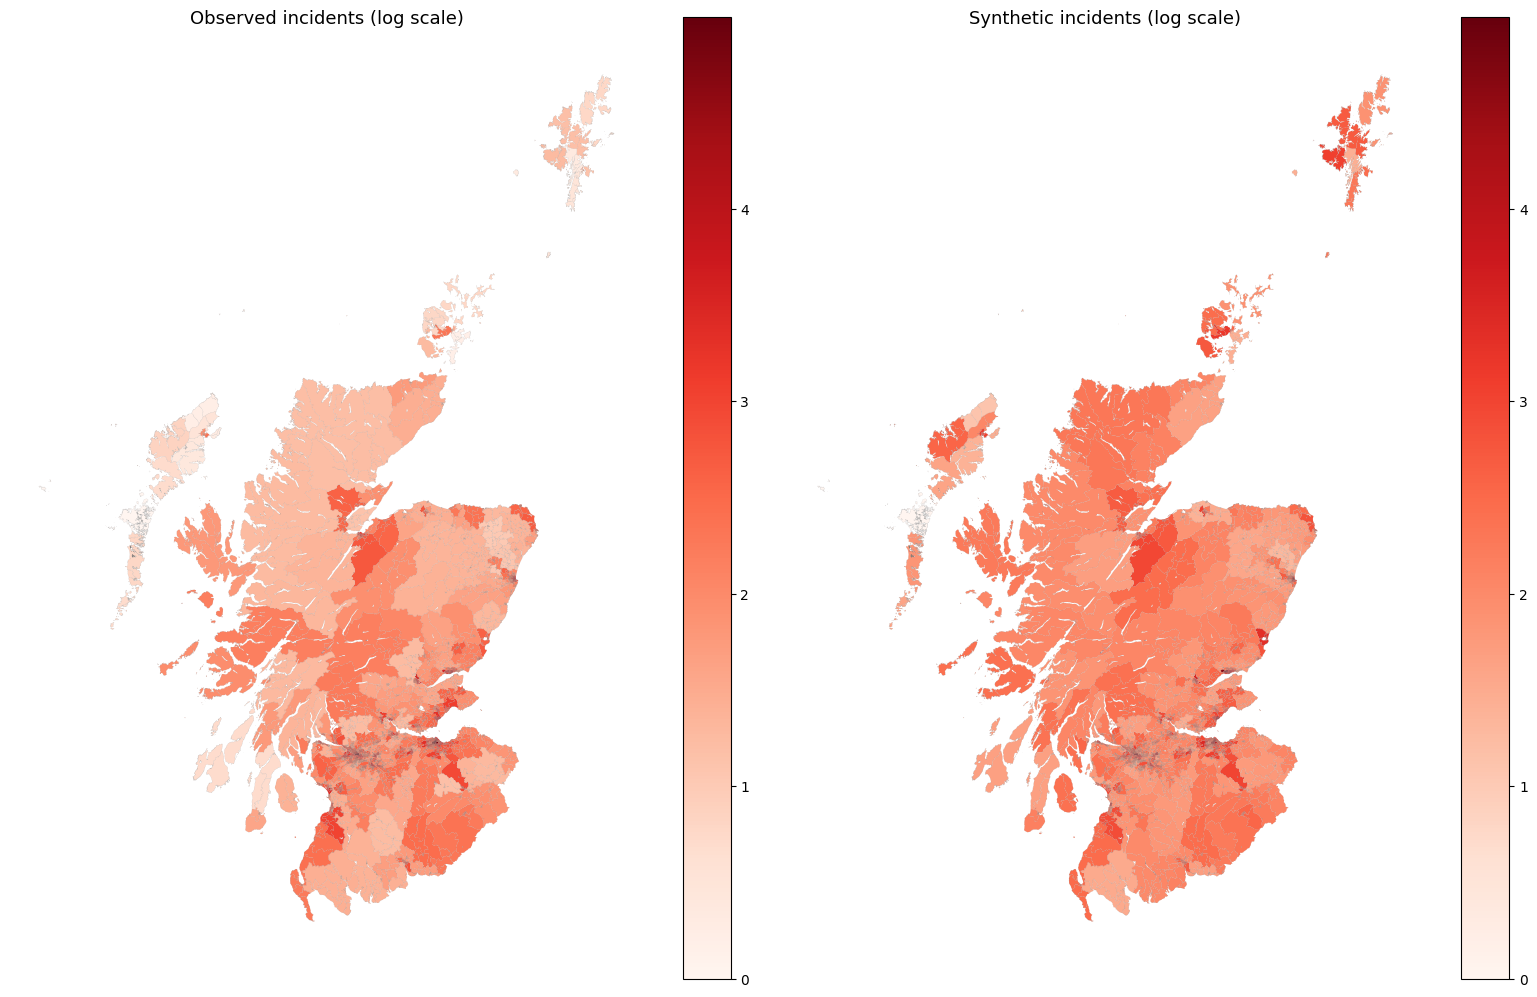

In [9]:
# ───────────────────────────  0.  HOUSEKEEPING  ───────────────────────────
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

df = df_filtered.copy()

# If your lookup hasn’t been renamed yet, do it once:
lookup = (lookup
          .rename(columns={"DZ2011_Code": "DataZone"})  # <-- change only if needed
          [["DataZone", "MMWard_Name"]])                # keep essentials

# ───────────────────────────  0.1  CHECK FOR UNMAPPED WARDS  ───────────────────────────
lookup_wards = set(lookup["MMWard_Name"].unique())

obs_unique = set(df["multi_member_ward"].dropna().unique())
syn_unique = set(synthetic_data["multi_member_ward"].dropna().unique())

obs_missing = obs_unique - lookup_wards
syn_missing = syn_unique - lookup_wards

if obs_missing:
    print(f"⚠️ Observed wards not in lookup ({len(obs_missing)}): {sorted(obs_missing)[:10]}{'...' if len(obs_missing) > 10 else ''}")
else:
    print("✅ All observed wards are in lookup")

if syn_missing:
    print(f"⚠️ Synthetic wards not in lookup ({len(syn_missing)}): {sorted(syn_missing)[:10]}{'...' if len(syn_missing) > 10 else ''}")
else:
    print("✅ All synthetic wards are in lookup")

# ───────────────────────────  1.  WARD-LEVEL COUNTS  ───────────────────────────
for frame in (df, synthetic_data):
    frame["incident_count"] = 1  # one incident per row

obs_ward = (df
            .groupby("multi_member_ward", as_index=False)["incident_count"]
            .sum()
            .rename(columns={"multi_member_ward": "MMWard_Name",
                             "incident_count": "ward_incidents"}))

syn_ward = (synthetic_data
            .groupby("multi_member_ward", as_index=False)["incident_count"]
            .sum()
            .rename(columns={"multi_member_ward": "MMWard_Name",
                             "incident_count": "ward_incidents"}))

# ───────────────────────────  2.  EXPAND TO DATA-ZONE  ───────────────────────────
dz_per_ward = (lookup
               .groupby("MMWard_Name")
               .size()
               .rename("n_dz")
               .reset_index())

def expand_to_dz(ward_counts: pd.DataFrame) -> pd.DataFrame:
    out = (ward_counts
           .merge(lookup, on="MMWard_Name", how="left")  # duplicate per DZ
           .merge(dz_per_ward, on="MMWard_Name", how="left"))
    out["dz_incidents"] = out["ward_incidents"] / out["n_dz"]  # uniform share
    return out[["DataZone", "dz_incidents"]]

obs_dz = expand_to_dz(obs_ward)
syn_dz = expand_to_dz(syn_ward)

# ───────────────────────────  3.  LOAD & RENAME SHAPEFILE  ───────────────────────────
shp_path = "shape_files/SG_DataZone_Bdry_2011.shp"

shp = (gpd.read_file(shp_path)
       .rename(columns={"DZ_CODE": "DataZone"})  # CHANGE 'DZ_CODE' if needed
       .to_crs(epsg=4326))

# ───────────────────────────  4.  JOIN COUNTS → POLYGONS  ───────────────────────────
def attach_counts(gdf_base: gpd.GeoDataFrame,
                  dz_counts: pd.DataFrame) -> gpd.GeoDataFrame:
    gdf = (gdf_base.merge(dz_counts, on="DataZone", how="left")
                    .fillna({"dz_incidents": 0}))
    gdf["log_inc"] = np.log1p(gdf["dz_incidents"])  # log(x+1)
    return gdf

gdf_obs = attach_counts(shp, obs_dz)
gdf_syn = attach_counts(shp, syn_dz)

# Compute shared limits on the plotted variable (log_inc)
vmin = min(gdf_obs["log_inc"].min(), gdf_syn["log_inc"].min())
vmax = max(gdf_obs["log_inc"].max(), gdf_syn["log_inc"].max())

from matplotlib.colors import Normalize
norm = Normalize(vmin=vmin, vmax=vmax)

# ───────────────────────────  5.  PLOT SIDE-BY-SIDE  ───────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharex=True, sharey=True)

for ax, gdf_map, title in [
        (axes[0], gdf_obs, "Observed incidents (log scale)"),
        (axes[1], gdf_syn, "Synthetic incidents (log scale)")]:
    gdf_map.plot(
        column="log_inc",
        ax=ax,
        cmap="Reds",
        legend=True,
        edgecolor="grey",
        linewidth=0.05,
        norm=norm,           # <- shared scale
    )
    ax.set_title(title, fontsize=13)
    ax.axis("off")

plt.tight_layout()
plt.show()

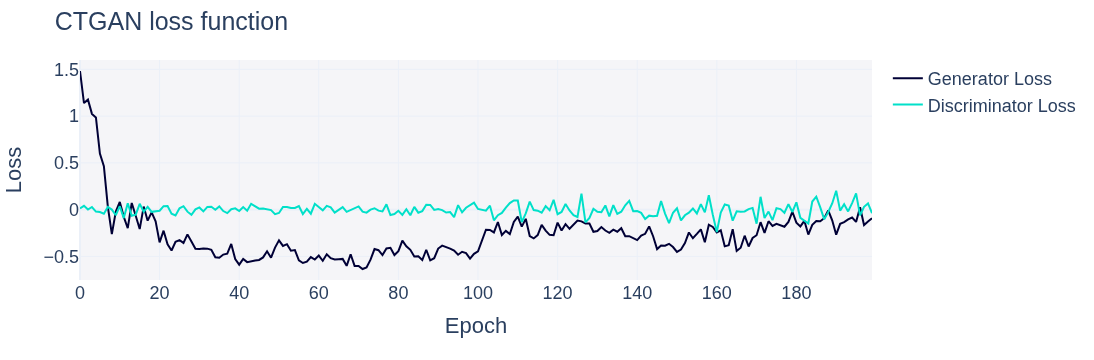

In [32]:
# Visualising the loss functions
fig = ctgan.get_loss_values_plot()
fig.show()

In [2]:
losses = ctgan.get_loss_values()
g_hist = losses["Generator Loss"].tolist()
d_hist = losses["Discriminator Loss"].tolist()

## Determining Convergance patterns of losses

In [6]:
import numpy as np
import pandas as pd

def find_convergence_epoch(
    loss_df: pd.DataFrame,
    *,
    window: int = 25,         
    epsilon: float = 0.10,    
    check_drift: bool = False,
    drift: float = 0.20
) -> int | None:
    
    g = loss_df["Generator Loss"].to_numpy()
    d = loss_df["Discriminator Loss"].to_numpy()
    epochs = loss_df["Epoch"].to_numpy()

    # centred moving average (pad equally left/right)
    pad = window // 2
    g_smooth = np.convolve(np.pad(g, pad, mode="edge"),
                           np.ones(window)/window, mode="valid")
    d_smooth = np.convolve(np.pad(d, pad, mode="edge"),
                           np.ones(window)/window, mode="valid")

    for i in range(window, len(loss_df)):
        g_win, d_win = g_smooth[i-window:i], d_smooth[i-window:i]
        gap_ok = np.abs(g_win - d_win).mean() <= epsilon

        if check_drift:
            drift_ok = (g_win.ptp() <= drift) and (d_win.ptp() <= drift)
            if gap_ok and drift_ok:
                return int(epochs[i])
        else:
            if gap_ok:
                return int(epochs[i])

    return None
    
losses = ctgan.get_loss_values()
conv = find_convergence_epoch(losses,
                              window=10,     
                              epsilon=0.10,  
                              check_drift=False)

print("Convergence epoch:", conv)

Convergence epoch: 159


In [7]:
i = 800                                   # epoch index to inspect
g_win = losses["Generator Loss"][i-25:i].mean()
d_win = losses["Discriminator Loss"][i-25:i].mean()
print("mean gaps:", abs(g_win - d_win))


mean gaps: 0.4141748642921448


In [8]:
window = 25
i = 800

g_win = losses["Generator Loss"][i-window:i]
d_win = losses["Discriminator Loss"][i-window:i]

print("G  max–min:", g_win.max() - g_win.min())
print("D  max–min:", d_win.max() - d_win.min())


G  max–min: 0.2978147268295288
D  max–min: 0.208082914352417


In [13]:
import numpy as np
import pandas as pd

def find_convergence_epoch(
    loss_df: pd.DataFrame,
    *,
    smooth_span: int = 25,     # EMA span  (≈ look-back window)
    window: int      = 10,     # how many smoothed points to evaluate
    epsilon: float   = 0.05,   # max mean |G-D| inside window
    drift: float     = 0.10,   # max (max-min) of each EMA inside window
) -> int | None:
    """
    Return the first epoch where the *smoothed* generator & discriminator
    losses are (a) close and (b) not drifting.

    Parameters
    ----------
    loss_df : DataFrame from `ctgan.get_loss_values()`
    smooth_span : int
        Span for EMA smoothing; 25 ≈ moderately damped.
    window : int
        Number of *smoothed* points to consider for each test.
    epsilon : float
        Convergence gap tolerance.
    drift : float
        Allowed max-min drift (on smoothed values).

    Returns
    -------
    int  — epoch index (1-based) where convergence is first detected,
    or None if never satisfied.
    """
    # 1 · EMA smooth  ----------------------------------------------------------
    g_s = loss_df["Generator Loss"].ewm(span=smooth_span,
                                        adjust=False).mean().to_numpy()
    d_s = loss_df["Discriminator Loss"].ewm(span=smooth_span,
                                            adjust=False).mean().to_numpy()
    epochs = loss_df["Epoch"].to_numpy()

    # 2 · slide a window over the smoothed series  -----------------------------
    for i in range(window, len(loss_df)):
        g_win, d_win = g_s[i-window:i], d_s[i-window:i]

        gap_ok   = np.abs(g_win - d_win).mean() <= epsilon
        drift_ok = (g_win.ptp() <= drift) and (d_win.ptp() <= drift)

        if gap_ok and drift_ok:
            return int(epochs[i])      # first epoch that passes

    return None


In [14]:
losses = ctgan.get_loss_values()      # SDV 1.23.0
conv_epoch = find_convergence_epoch(
    losses,
    smooth_span=25,   # ← tweak if you want more/less smoothing
    window=10,
    epsilon=0.05,
    drift=0.10,       # now tested on smoothed losses
)

print("Convergence epoch:", conv_epoch)   # should print ~ 800

Convergence epoch: 177


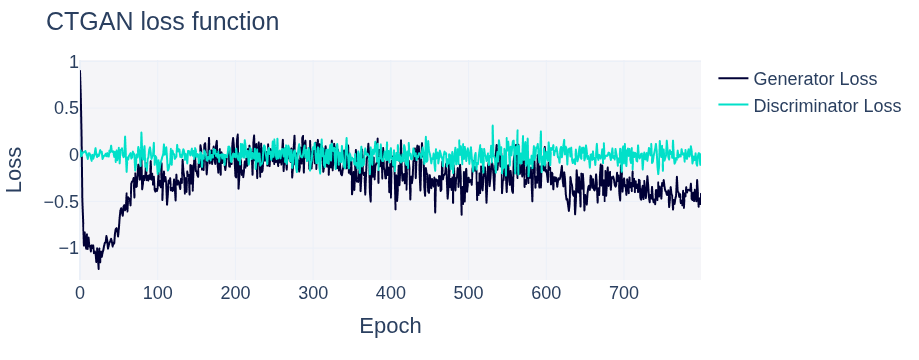

In [15]:
ctgan.get_loss_values_plot()